### Pip Install the Necessary Libraries

In [ ]:
!pip install pennylane -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 38.9 MB/s eta 0:00:00


### Importing all the Necessary Libraries

In [ ]:
from PIL import Image
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc,confusion_matrix,classification_report
import tensorflow as tf
from tensorflow.keras.utils import custom_object_scope
from sklearn.preprocessing import label_binarize
from itertools import cycle
from tensorflow.keras.applications import MobileNetV3Large,MobileNetV3Small
from IPython.display import Audio,display
import shutil
import librosa
import pennylane as qml
import os
import numpy as np

### Set Global Variables

In [ ]:
tf.get_logger().setLevel('ERROR')

In [ ]:
# Set the path to the original directory containing 10 folders
original_directory = "/home/siddhant/ESC-10"

# Set the paths for the train and valid directories
train_directory = "/home/siddhant/ESC-10/train"
valid_directory = "/home/siddhant/ESC-10/valid"

# Create train and valid directories if they don't exist
os.makedirs(train_directory, exist_ok=True)
os.makedirs(valid_directory, exist_ok=True)

In [ ]:
n_qubits = 4
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}
dev = qml.device("default.qubit", wires=n_qubits)

### Restructure the Directory

In [ ]:
for folder_name in os.listdir(original_directory):
    if folder_name == 'train' or folder_name == 'valid':
        continue
    folder_path = os.path.join(original_directory, folder_name)

    # Create the corresponding train and valid folders
    train_folder_path = os.path.join(train_directory, folder_name)
    valid_folder_path = os.path.join(valid_directory, folder_name)
    os.makedirs(train_folder_path, exist_ok=True)
    os.makedirs(valid_folder_path, exist_ok=True)

    # Get a list of audio files in the original folder
    audio_files = [f for f in os.listdir(folder_path) if f.endswith(".ogg")]

    # Create a corresponding folder in the valid directory for log-mel spectrograms
    train_mel_folder_path = os.path.join(train_directory, folder_name + "_mel")
    valid_mel_folder_path = os.path.join(valid_directory, folder_name + "_mel")
    os.makedirs(train_mel_folder_path, exist_ok=True)
    os.makedirs(valid_mel_folder_path, exist_ok=True)

    # Move 30 audio files to the train folder
    train_files = audio_files[:30]
    for file_name in train_files:
        src = os.path.join(folder_path, file_name)
        dst = os.path.join(train_folder_path, file_name)
        shutil.move(src, dst)

        audio_file_path = os.path.join(train_folder_path, file_name)
        y, sr = librosa.load(audio_file_path)  # Load audio file
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, power=1.0)  # Compute mel-spectrogram with power=1
        log_mel_spectrogram = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)  # Convert to log scale
        mel_file_path = os.path.join(train_mel_folder_path, file_name.replace(".ogg", ".npy"))  # Output file path
        np.save(mel_file_path, log_mel_spectrogram)  # Save log-mel spectrogram as a numpy array

    # Move 10 audio files to the valid folder
    valid_files = audio_files[30:40]
    for file_name in valid_files:
        src = os.path.join(folder_path, file_name)
        dst = os.path.join(valid_folder_path, file_name)
        shutil.move(src, dst)

        # Convert audio files to log-mel spectrograms and save them
        audio_file_path = os.path.join(valid_folder_path, file_name)
        y, sr = librosa.load(audio_file_path)  # Load audio file
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, power=1.0)  # Compute mel-spectrogram with power=1
        log_mel_spectrogram = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)  # Convert to log scale
        mel_file_path = os.path.join(valid_mel_folder_path, file_name.replace(".ogg", ".npy"))  # Output file path
        np.save(mel_file_path, log_mel_spectrogram)  # Save log-mel spectrogram as a numpy array

***The final directory structure would look like this before training***

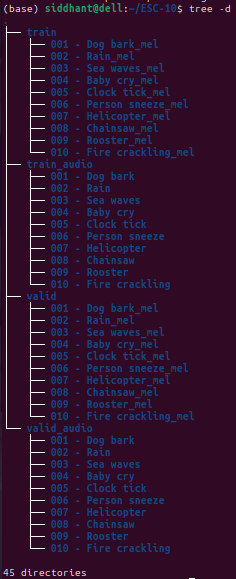

### Data Preparation for training

In [ ]:
# Get the list of classes based on the subfolders present in the train folder
class_names = sorted(os.listdir(train_directory))

# Load the log-mel spectrograms and their corresponding labels from the train folder
train_data = []
train_labels = []
for class_name in class_names:
    class_folder = os.path.join(train_directory, class_name)
    for file_name in os.listdir(class_folder):
        file_path = os.path.join(class_folder, file_name)
        spectrogram = np.load(file_path)
        spectrogram_resized = np.array(Image.fromarray(spectrogram).resize((128,128)))
        train_data.append(spectrogram_resized)
        train_labels.append(class_names.index(class_name))

train_data = np.array(train_data)
train_labels = np.array(train_labels)

# Load the log-mel spectrograms and their corresponding labels from the valid folder
valid_data = []
valid_labels = []
for class_name in class_names:
    class_folder = os.path.join(valid_directory, class_name)
    for file_name in os.listdir(class_folder):
        file_path = os.path.join(class_folder, file_name)
        spectrogram = np.load(file_path)
        spectrogram_resized = np.array(Image.fromarray(spectrogram).resize((128,128)))
        valid_data.append(spectrogram_resized)
        valid_labels.append(class_names.index(class_name))

valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

# Reshape the data to have an additional dimension
train_data = np.expand_dims(train_data, axis=-1)
valid_data = np.expand_dims(valid_data, axis=-1)

# Convert labels to categorical
num_classes = len(class_names)
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
valid_labels = tf.keras.utils.to_categorical(valid_labels, num_classes)

### Curating a Quantum Layer via Pennylane

In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [ ]:
@qml.qnode(dev)
def quantum_net(inputs, weights):
    """
    The variational quantum circuit.
    """

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(inputs)

    # Sequence of trainable variational layers
    for k in range(n_layers):
        entangling_layer(n_qubits)
        RY_layer(weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

### Curating the Hybrid Quantum-Classical Model Architecture

In [ ]:
# Step 1: Create the MobileNetV3Large base model
base_model = MobileNetV3Large(include_top=True, weights="imagenet")

# Step 2: Remove the last layer of the base model
base_model.layers.pop()

# Step 3: Freeze the remaining layers
for layer in base_model.layers:
    layer.trainable = False

# Step 4: Define the rest of your model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=train_data.shape[1:]),
    tf.keras.layers.Conv2D(3, kernel_size=(1, 1), activation='linear'),  # Convert grayscale to RGB
    base_model,
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(4, activation="elu"),
    qml.qnn.KerasLayer(quantum_net, weight_shapes, output_dim=n_qubits),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

### Initating the Model Training

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, train_labels, batch_size=4, epochs=50, validation_data=(valid_data, valid_labels))

Epoch 1/50
75/75 [==============================] - 138s 2s/step - loss: 2.2794 - accuracy: 0.1233 - val_loss: 2.1752 - val_accuracy: 0.2200
Epoch 2/50
75/75 [==============================] - 155s 2s/step - loss: 2.0856 - accuracy: 0.2767 - val_loss: 2.0700 - val_accuracy: 0.3000
Epoch 3/50
75/75 [==============================] - 143s 2s/step - loss: 2.0184 - accuracy: 0.3300 - val_loss: 2.0778 - val_accuracy: 0.2900
Epoch 4/50
75/75 [==============================] - 151s 2s/step - loss: 1.9839 - accuracy: 0.3300 - val_loss: 1.9613 - val_accuracy: 0.2800
Epoch 5/50
75/75 [==============================] - 150s 2s/step - loss: 1.8913 - accuracy: 0.3967 - val_loss: 1.8887 - val_accuracy: 0.4000
Epoch 6/50
75/75 [==============================] - 143s 2s/step - loss: 1.8253 - accuracy: 0.4067 - val_loss: 1.9249 - val_accuracy: 0.3300
Epoch 7/50
75/75 [==============================] - 148s 2s/step - loss: 1.7760 - accuracy: 0.4400 - val_loss: 1.9301 - val_accuracy: 0.3600
Epoch 8/50
75

### Saving the Model

In [ ]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                Output Shape              Param #   
conv2d_22 (Conv2D)          (None, 128, 128, 3)       6         
                                                                 
MobilenetV3large (Functiona  (None, 1000)             5507432   
l)                                                               
                                                                 
dense_114 (Dense)           (None, 1024)              1025024   
                                                                 
dense_115 (Dense)           (None, 512)               524800    
                                                                 
dense_116 (Dense)           (None, 256)               131328    
                                                                 
dense_117 (Dense)           (None, 4)                 1028      
                                                            

In [ ]:
custom_objects = {'KerasLayer': qml.qnn.KerasLayer(quantum_net, weight_shapes,output_dim=n_qubits)}

In [ ]:
with custom_object_scope(custom_objects):
    model.save_weights("final.h5")

### Visualizations - Post-training Analysis

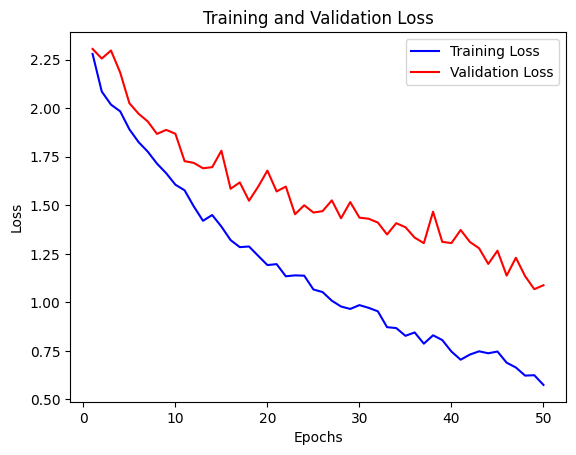

In [ ]:
# the metrics were extracted from the logs which were saved
epochs = range(1, len(losses) + 1)

plt.plot(epochs, losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

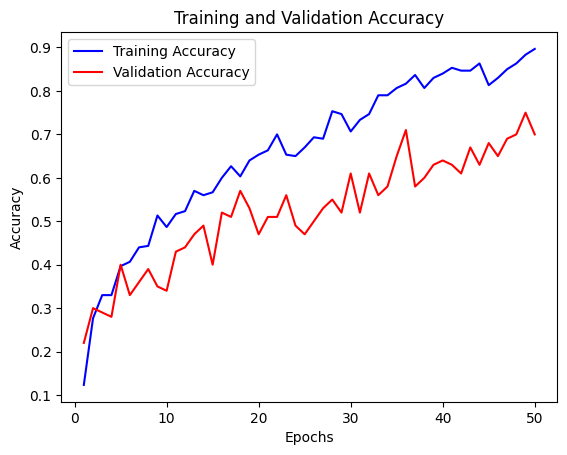

In [ ]:
epochs = range(1, len(accuracies) + 1)

plt.plot(epochs, accuracies, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

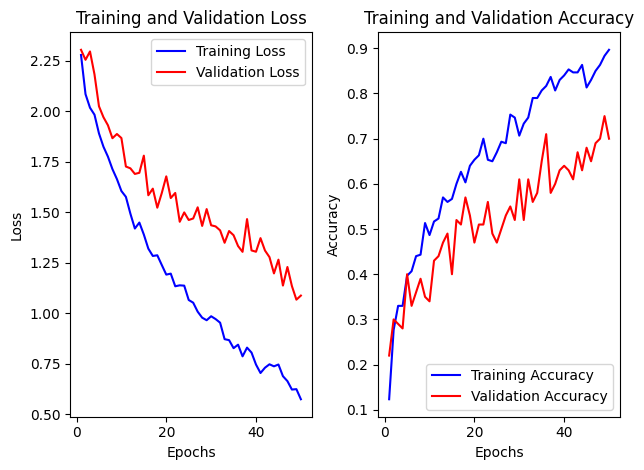

In [ ]:
epochs = range(1, len(losses) + 1)

# Subplot for Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

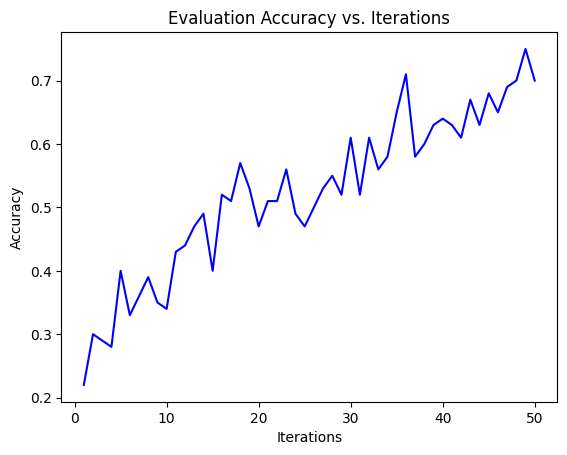

In [ ]:
iterations = range(1, len(accuracies) + 1)

plt.plot(iterations, val_accuracies, 'b')
plt.title('Evaluation Accuracy vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.show()

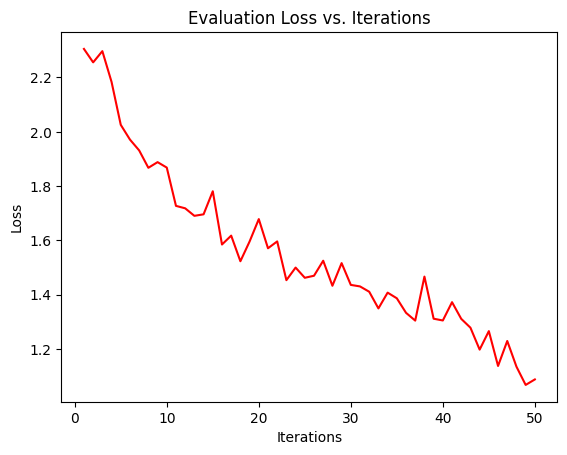

In [ ]:
iterations = range(1, len(losses) + 1)

plt.plot(iterations, val_losses, 'r')
plt.title('Evaluation Loss vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

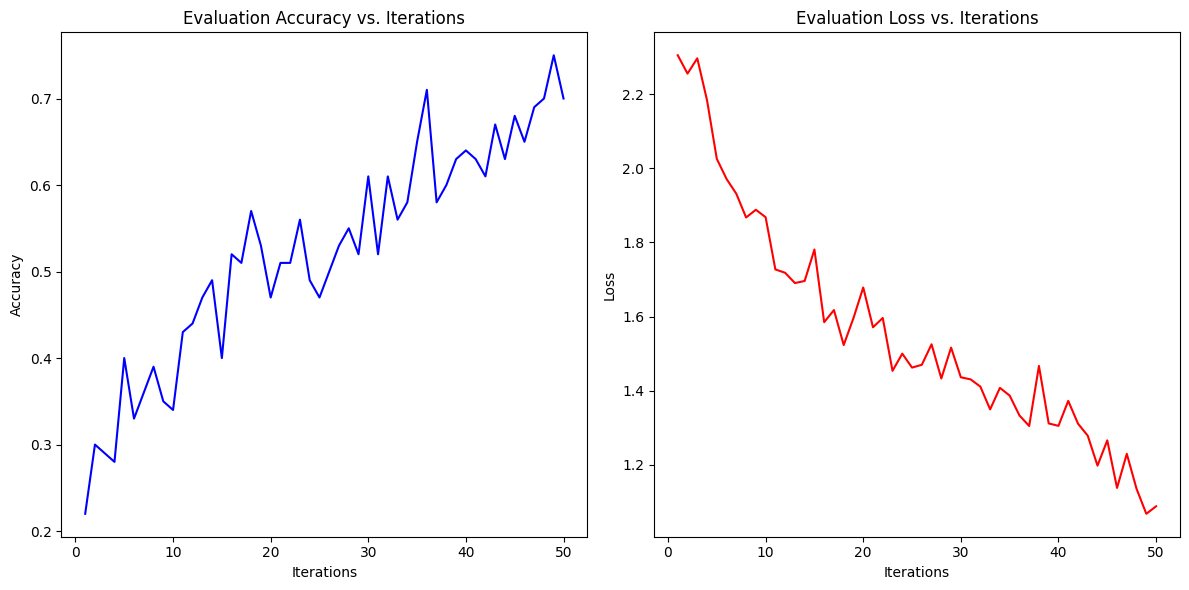

In [ ]:
iterations = range(1, len(accuracies) + 1)

plt.figure(figsize=(12, 6))

# Plot Evaluation Accuracy
plt.subplot(1, 2, 1)
plt.plot(iterations, val_accuracies, 'b')
plt.title('Evaluation Accuracy vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

# Plot Evaluation Loss
plt.subplot(1, 2, 2)
plt.plot(iterations, val_losses, 'r')
plt.title('Evaluation Loss vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


### Testing on the Original Dataset

In [ ]:
combined_data = np.concatenate((train_data, valid_data), axis=0)
combined_labels = np.concatenate((train_labels, valid_labels), axis=0)
combined_predictions = model.predict(combined_data)

13/13 [==============================] - 53s 4s/step


In [ ]:
converted_predictions = list()

for pred_array in combined_predictions:
    output_array = np.zeros_like(pred_array)
    output_array[np.argmax(pred_array)] = 1
    converted_predictions.append(output_array)

converted_predictions = np.array(converted_predictions)

In [ ]:
final_labels = np.argmax(combined_labels,axis=1)
final_predictions = np.argmax(converted_predictions,axis=1)

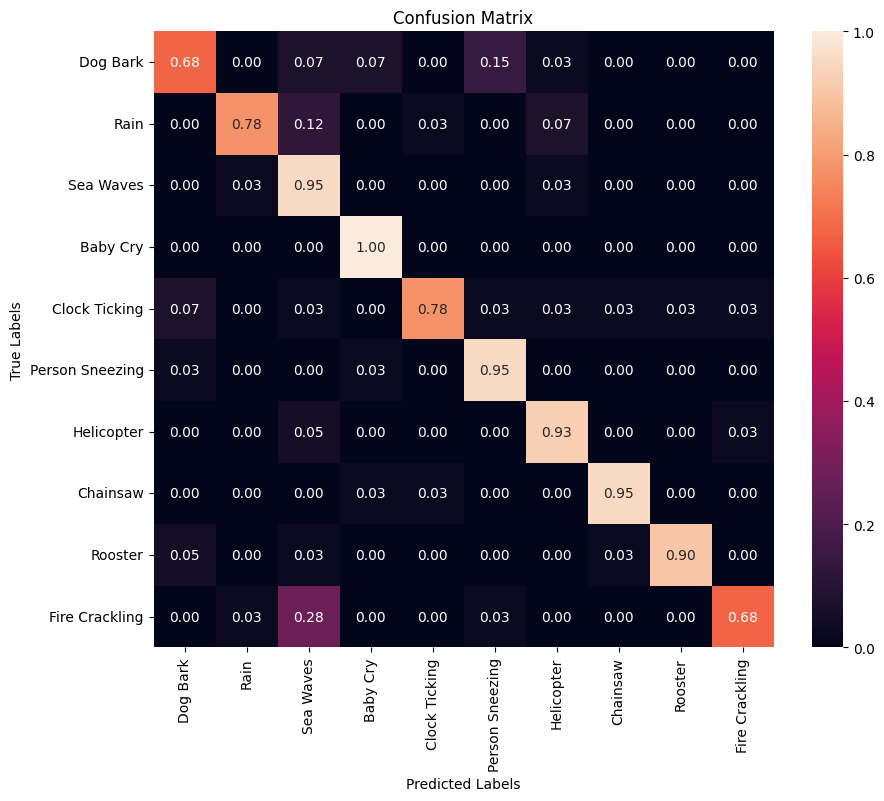

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

esc_10_classes = [
    'Dog Bark',
    'Rain',
    'Sea Waves',
    'Baby Cry',
    'Clock Ticking',
    'Person Sneezing',
    'Helicopter',
    'Chainsaw',
    'Rooster',
    'Fire Crackling'
]

plot_confusion_matrix(final_labels, final_predictions, esc_10_classes)

In [ ]:
print(classification_report(final_labels, final_predictions))

              precision    recall  f1-score   support

           0       0.82      0.68      0.74        40
           1       0.94      0.78      0.85        40
           2       0.62      0.95      0.75        40
           3       0.89      1.00      0.94        40
           4       0.94      0.78      0.85        40
           5       0.83      0.95      0.88        40
           6       0.86      0.93      0.89        40
           7       0.95      0.95      0.95        40
           8       0.97      0.90      0.94        40
           9       0.93      0.68      0.78        40

    accuracy                           0.86       400
   macro avg       0.87      0.86      0.86       400
weighted avg       0.87      0.86      0.86       400



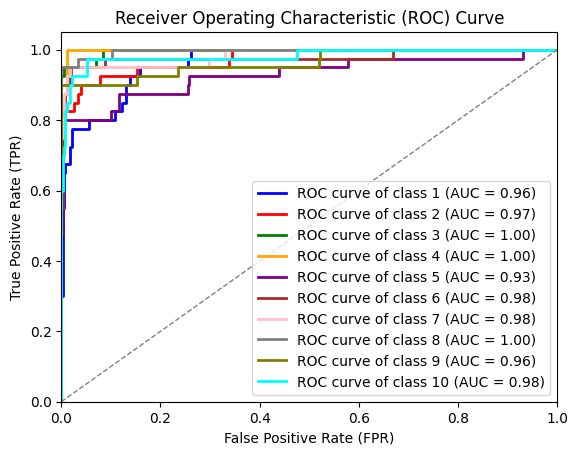

In [ ]:
true_labels = final_labels
predicted_probs = combined_predictions

# Binarize the true labels
n_classes = 10
binarized_labels = label_binarize(true_labels, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class %d (AUC = %0.2f)' % (i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()